# Build LLM from scatch
https://pub.towardsai.net/build-your-own-llama-3-architecture-from-scratch-using-pytorch-2ce1ecaa901c

In [1]:
# Import necessary libraries
import torch
from torch import nn
from torch.nn import functional as F

import math
import numpy as np
import time
from dataclasses import dataclass
from typing import Optional, Tuple, List
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
### Step 1: Input Block ###

# Using Tiny Shakespeare dataset for character-level tokenizer. Some part of the following character-level tokenizer is referenced from Andrej karpathy's GitHub (https://github.com/karpathy/nanoGPT/blob/master/data/shakespeare_char/prepare.py) which I found is explained very well.
# Load tiny_shakespeare data file (https://github.com/tamangmilan/llama3/blob/main/tiny_shakespeare.txt)

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'   # Assign device to cuda or cpu based on availability

# Load tiny_shakespeare data file.
with open('tiny_shakespeare.txt', 'r') as f:
  data = f.read()

# Prepare vocabulary by taking all the unique characters from the tiny_shakespeare data
vocab = sorted(list(set(data)))

# Training Llama 3 model requires addtional tokens such as <|begin_of_text|>, <|end_of_text|> and <|pad_id|>, we'll add them into vocabulary
vocab.extend(['<|begin_of_text|>','<|end_of_text|>','<|pad_id|>'])
vocab_size = len(vocab)

# Create a mapping between characters with corresponding integer indexes in vocabulary.
# This is important to build tokenizers encode and decode functions.
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

# Tokenizers encode function: take a string, output a list of integers
def encode(s):
  return [stoi[ch] for ch in s]

# Tokenizers decode function: take a list of integers, output a string
def decode(l):
  return ''.join(itos[i] for i in l)

# Define tensor token variable to be used later during model training
token_bos = torch.tensor([stoi['<|begin_of_text|>']], dtype=torch.int, device=device)
token_eos = torch.tensor([stoi['<|end_of_text|>']], dtype=torch.int, device=device)
token_pad = torch.tensor([stoi['<|pad_id|>']], dtype=torch.int, device=device)

prompts = "Hello World"
encoded_tokens = encode(prompts)
decoded_text = decode(encoded_tokens)

### Test: Input Block Code ###
# You need to take out the triple quotes below to perform testing
"""
print(f"Lenth of shakespeare in character: {len(data)}")
print(f"The vocabulary looks like this: {''.join(vocab)}\n")
print(f"Vocab size: {vocab_size}")
print(f"encoded_tokens: {encoded_tokens}")
print(f"decoded_text: {decoded_text}")
"""
### Test Results: ###
"""
Lenth of shakespeare in character: 1115394
The vocabulary looks like this: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<|begin_of_text|><|end_of_text|><|pad_id|>

Vocab size: 68
encoded_tokens: [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]
decoded_text: Hello World
"""

"\nLenth of shakespeare in character: 1115394\nThe vocabulary looks like this: \n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<|begin_of_text|><|end_of_text|><|pad_id|>\n\nVocab size: 68\nencoded_tokens: [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]\ndecoded_text: Hello World\n"

In [3]:
# Step2: The Decoder Block
# Note: Since the Llama 3 model is developed by Meta, so to be in sync with their codebase and for future compatibility,
# I will use most of the code from Meta GitHub with some necessary changes required to achieve our goal.

# Define parameters dataclass: we'll use these parameters during model building, training and inference.
# Note: Since we want to see the results of training and inferencing faster rather than focusing on high accuracy, we're taking lower values for most of the parameters which are set higher in the Llama 3 model.

@dataclass
class ModelArgs:
    dim: int = 512              # embedding dimension
    n_layers: int = 8           # number of model decoder blocks
    n_heads: int = 8            # number of heads for queries embedding
    n_kv_heads: int = 4         # number of heads for keys and values embedding
    vocab_size: int = len(vocab) # Length of vocabulary
    multiple_of: int = 256        # Require to calculate dim of feedfoward network
    ffn_dim_multiplier: Optional[float] = None  # Require to calculate dim of feedfoward network
    norm_eps: float = 1e-5                       # Default Epsilon value set for the RMSNorm calculation
    rope_theta: float = 10000.0   # Default theta value for the RePE calculation

    max_batch_size: int = 10     # Max batch size
    max_seq_len: int = 256         # Max sequence length

    epochs: int = 250  #default=2500             # Total number of training iteration
    log_interval: int = 10        # Number of interval to print the logs and loss values   
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'   # Assign device to cuda or cpu based on availability 

In [4]:
## Step2a: The RMSNorm

class RMSNorm(nn.Module):
  def __init__(self, dim: int, eps: float = 1e-6):
    super().__init__()
    device = ModelArgs.device
    self.eps = eps
    # Scaling parameter gamma, initialized with one and the no of parameters is equal to the size of dim
    self.weight = nn.Parameter(torch.ones(dim).to(device))

  def _norm(self, x):
    return x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps).to(device)

  def forward(self, x):
    #Shape: x[bs,seq,dim]
    output = self._norm(x.float()).type_as(x)

    #Shape: x[bs,seq,dim] -> x_norm[bs,seq,dim]
    return output * self.weight

### Test: RMSNorm Code ###
# You need take out the triple quotes below to perform testing
"""
x = torch.randn((ModelArgs.max_batch_size, ModelArgs.max_seq_len, ModelArgs.dim), device=device)
rms_norm = RMSNorm(dim=ModelArgs.dim)
x_norm = rms_norm(x)

print(f"Shape of x: {x.shape}")
print(f"Shape of x_norm: {x_norm.shape}")
"""
### Test Results: ###
"""
Shape of x: torch.Size([10, 256, 512])
Shape of x_norm: torch.Size([10, 256, 512])
"""

'\nShape of x: torch.Size([10, 256, 512])\nShape of x_norm: torch.Size([10, 256, 512])\n'

In [5]:
## Step2b: The RoPE(rotational embedding)
def precompute_freqs_cis(dim:int, seq_len: int, theta: float=10000.0):
  # Computing Theta value for each dim pair which is dim/2
  device = ModelArgs.device
  freqs = 1.0 / (theta ** (torch.arange(0, dim, 2,device=device)[:(dim//2)].float()/dim))

  # Computing range of positions(m) in the sequence
  t = torch.arange(seq_len, dtype=torch.float32, device=device)

  # freqs gives all the Theta value range for all the position of tokens in the sequence
  freqs = torch.outer(t, freqs).to(device)

  # This is the rotation matrix which needs to be converted to Polar form in order to perform rotation to the embedding
  freqs_cis = torch.polar(torch.ones_like(freqs).to(device), freqs).to(device)
  return freqs_cis

def reshape_for_broadcast(freqs_cis, x):
  ndim = x.ndim
  assert 0<=1<ndim
  assert freqs_cis.shape == (x.shape[1],x.shape[-1]), "the last two dimension of freqs_cis, x must match"
  shape = [d if i==1 or i==ndim-1 else 1 for i,d in enumerate(x.shape)]
  return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor)->Tuple[torch.Tensor, torch.Tensor]:
  device = ModelArgs.device
  # Applying rotary positional encoding to both query and key embedding together
  # First: The last dimension of xq and xk embedding needs to be reshaped to make it a pair. As rotation matrix is applied to each pair of dim.
  # Next: convert both xq and xk to complex number as the rotation matrix is only applicable to complex number
  xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2)).to(device)    #xq_:[bsz, seq_len, n_heads, head_dim/2]
  xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2)).to(device)    #xk_:[bsz, seq_len, n_heads, head_dim/2]

  # The rotation matrix(freqs_cis) dimensions across seq_len(dim=1) and head_dim(dim=3) should match with the embedding
  # Also, the shape freqs_cis should be the same with xq and xk, hence change the shape of freqs_cis:[seq_len,head_dim] -> freqs_cis:[1,seq_len,1,head_dim]
  freqs_cis = reshape_for_broadcast(freqs_cis, xq_)

  #Finally, perform rotation operation by multiplying with freqs_cis.
  #After the rotation is completed, convert both xq_out and xk_out back to real number and return
  xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3).to(device) #xq_out:[bsz, seq_len, n_heads, head_dim]
  xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3).to(device) #xk_out:[bsz, seq_len, n_heads, head_dim]
  return xq_out.type_as(xq), xk_out.type_as(xk)

### Test: RoPE Code ###
# Note: x_norm is calculated during RMSNorm and is being used for testing here.
# You need take out the triple quotes below to perform testing
"""
head_dim = ModelArgs.dim//ModelArgs.n_heads
wq = nn.Linear(ModelArgs.dim, ModelArgs.n_heads * head_dim, bias=False, device=device)
wk = nn.Linear(ModelArgs.dim, ModelArgs.n_kv_heads * head_dim, bias=False, device=device)
xq = wq(x_norm)
xk = wk(x_norm)
print(f"xq.shape: {xq.shape}")
print(f"xk.shape: {xk.shape}")

xq = xq.view(xq.shape[0],xq.shape[1],ModelArgs.n_heads, head_dim)
xk = xk.view(xk.shape[0],xk.shape[1],ModelArgs.n_kv_heads, head_dim)
print(f"xq.re-shape: {xq.shape}")
print(f"xk.re-shape: {xk.shape}")

freqs_cis = precompute_freqs_cis(dim=head_dim, seq_len=ModelArgs.max_seq_len)
print(f"freqs_cis.shape: {freqs_cis.shape}")

xq_rotate, xk_rotate = apply_rotary_emb(xq, xk, freqs_cis)
print(f"xq_rotate.shape: {xq_rotate.shape}")
print(f"xk_rotate.shape: {xk_rotate.shape}")
"""
### Test Results: ###
"""
xq.shape: torch.Size([10, 256, 512])
xk.shape: torch.Size([10, 256, 256])
xq.re-shape: torch.Size([10, 256, 8, 64])
xk.re-shape: torch.Size([10, 256, 4, 64])
freqs_cis.shape: torch.Size([256, 32])
xq_rotate.shape: torch.Size([10, 256, 8, 64])
xk_rotate.shape: torch.Size([10, 256, 4, 64])
"""

'\nxq.shape: torch.Size([10, 256, 512])\nxk.shape: torch.Size([10, 256, 256])\nxq.re-shape: torch.Size([10, 256, 8, 64])\nxk.re-shape: torch.Size([10, 256, 4, 64])\nfreqs_cis.shape: torch.Size([256, 32])\nxq_rotate.shape: torch.Size([10, 256, 8, 64])\nxk_rotate.shape: torch.Size([10, 256, 4, 64])\n'

In [6]:
## The Attention Block [Step2c: The KV Cache; Step2d: Group Query Attention]
## As mentioned before, the naming convention follows original the meta's LLama3 GitHub

class Attention(nn.Module):
  def __init__(self, args: ModelArgs):
    super().__init__()
    self.args = args
    # Embedding dimension
    self.dim = args.dim
    # Number of heads assigned to Query
    self.n_heads = args.n_heads
    # Number of heads assigned to Key and values. If "None", the number will be same as Query.
    self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
    # Dimension of each head relative to model dimension
    self.head_dim = args.dim // args.n_heads
    # Number of repetition in order to make time Key, Value heads to match Query heads number
    self.n_rep = args.n_heads // args.n_kv_heads

    # Weight initialize for Keys, Querys, Values and Oupt. Notice that the out_feature value of weight for q and kv are based on it's heads
    self.wq = nn.Linear(self.dim, self.n_heads * self.head_dim, bias=False, device=device)
    self.wk = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias=False, device=device)
    self.wv = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias=False, device=device)
    self.wo = nn.Linear(self.n_heads * self.head_dim, self.dim, bias=False, device=device)

    # Initialize caches to store Key, Values at start. (KV Cache Implementation)
    self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)
    self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)

  def forward(self, x: torch.Tensor, start_pos, inference):
    # Shape of the input embedding: [bsz,seq_len,dim]
    bsz, seq_len, _ = x.shape
    # Mask will be used during 'Training' and is not required for 'inference' due to the use of KV cache.
    mask = None

    xq = self.wq(x)  #x[bsz,seq_len,dim]*wq[dim,n_heads * head_dim] -> q[bsz,seq_len,n_heads * head_dim]
    xk = self.wk(x)  #x[bsz,seq_len,dim]*wq[dim,n_kv_heads * head_dim] -> k[bsz,seq_len,n_kv_heads * head_dim]
    xv = self.wv(x)  #x[bsz,seq_len,dim]*wq[dim,n_kv_heads * head_dim] -> v[bsz,seq_len,n_kv_heads * head_dim]

    # Reshaping Querys, Keys and Values by their number of heads. (Group Query Attention Implementation)
    xq = xq.view(bsz, seq_len, self.n_heads, self.head_dim)      #xq[bsz,seq_len,n_heads, head_dim]
    xk = xk.view(bsz, seq_len, self.n_kv_heads, self.head_dim)   #xk[bsz,seq_len,n_kv_heads, head_dim]
    xv = xv.view(bsz, seq_len, self.n_kv_heads, self.head_dim)   #xv[bsz,seq_len,n_kv_heads, head_dim]

    # Model - Inference Mode: kv-cache is enabled at inference mode only.
    if inference:
      # Compute rotation matrix for each position in the sequence
      freqs_cis = precompute_freqs_cis(dim=self.head_dim, seq_len=self.args.max_seq_len * 2)
      # During inferencing, we should only take the rotation matrix range from the current position of the tokens.
      freqs_cis = freqs_cis[start_pos : start_pos + seq_len]
      # Apply RoPE to Queries and Keys embeddings
      xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

      self.cache_k = self.cache_k.to(xq)
      self.cache_v = self.cache_v.to(xq)
      # Store Keys and Values token embedding into their respective cache [KV Cache Implementation]
      self.cache_k[:bsz, start_pos:start_pos + seq_len] = xk
      self.cache_v[:bsz, start_pos:start_pos + seq_len] = xv

      # Assign all the previous tokens embeddings upto current tokens position to Keys and Values variable for Attention Calculation
      keys = self.cache_k[:bsz, :start_pos + seq_len]
      values = self.cache_v[:bsz, :start_pos + seq_len]

      # At this point, they Keys and Values shape aren't same with Queries Embedding which has to be in order to computer attention score
      # Use repeat_kv function to make Keys,Values shape same as queries shape
      keys = repeat_kv(keys, self.n_rep)      #keys[bsz,seq_len,n_heads,head_dim]
      values = repeat_kv(values, self.n_rep)  #values[bsz,seq_len,n_heads,head_dim]

    # Mode - Training mode: KV-Cache not implemented
    else:
      # Compute rotation matrix and apply RoPE to queries and keys for for training.
      freqs_cis = precompute_freqs_cis(dim=self.head_dim, seq_len=self.args.max_seq_len)

      #xq[bsz,seq_len,n_heads, head_dim], xk[bsz,seq_len,n_heads, head_dim]
      xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

      # Use repeat_kv function to make Keys,Values shape same as the queries shape
      #keys[bsz,seq_len,n_heads,head_dim], #values[bsz,seq_len,n_heads,head_dim]
      keys = repeat_kv(xk, self.n_rep)
      values = repeat_kv(xv, self.n_rep)

      # For training mode, we'll compute mask and apply to the attention score later
      mask = torch.full((seq_len, seq_len),float("-inf"),device=self.args.device)
      mask = torch.triu(mask, diagonal=1).to(self.args.device)

    # To compute attention, we'll need to perform a transpose operation to reshape all queries, keys and values bring heads at dim 1 and seq at dim 2
    xq = xq.transpose(1,2)                  #xq[bsz,n_heads,seq_len,head_dim]
    keys = keys.transpose(1,2)              #keys[bsz,n_heads,seq_len,head_dim]
    values = values.transpose(1,2)          #values[bsz,n_heads,seq_len,head_dim]

    # Computing attention score
    scores = torch.matmul(xq, keys.transpose(2,3)).to(self.args.device)/math.sqrt(self.head_dim)
    if mask is not None:
      scores = scores + mask

    # Apply softmax to the attention score
    scores = F.softmax(scores.float(), dim=-1).type_as(xq)
    # Matrix multiplication of attention score with the values
    output = torch.matmul(scores, values).to(self.args.device)

    # We get the contextual embedding for each head
    # All heads need to be reshaped back and combined to give a single single contextual attention output
    # Shape change: output[bsz,n_heads,seq_len,head_dim] -> output[bsz,seq_len, n_heads,head_dim] -> output[bsz,seq_len, n_heads * head_dim]
    output = output.transpose(1,2).contiguous().view(bsz, seq_len, -1)

    # shape: output [bsz,seq_len,dim]
    return self.wo(output)

# If the number of keys/values heads is less than query heads, this function expands the key/values embeddings with the required number of repetition
def repeat_kv(x:torch.Tensor, n_rep: int)-> torch.Tensor:
  bsz, seq_len, n_kv_heads, head_dim = x.shape
  if n_rep == 1:
    return x
  return (
      x[:,:,:,None,:]
      .expand(bsz,seq_len,n_kv_heads,n_rep, head_dim)
      .reshape(bsz,seq_len,n_kv_heads * n_rep, head_dim)
  )


### Test: Repeat_kv function ###
# note: xk, x_norm is already calculated during RoPE, RMSNorm testing and is being used for testing here.
# You need take out the triple quotes below to perform testing
"""
n_rep = ModelArgs.n_heads // ModelArgs.n_kv_heads
keys = repeat_kv(xk, n_rep)
print(f"xk.shape: {xk.shape}")
print(f"keys.shape: {keys.shape}")

## Test: Attention function
# You need take out the triple quotes below to perform testing

attention = Attention(ModelArgs)
x_out = attention(x_norm,start_pos=0, inference=False)
print(f"x_out.shape: {x_out.shape}")
"""
### Test Results: ###
"""
xk.shape: torch.Size([10, 256, 4, 64])
keys.shape: torch.Size([10, 256, 8, 64])
x_out.shape: torch.Size([10, 256, 512])
"""

'\nxk.shape: torch.Size([10, 256, 4, 64])\nkeys.shape: torch.Size([10, 256, 8, 64])\nx_out.shape: torch.Size([10, 256, 512])\n'

In [7]:
## Step2e: The Feedfoward Network (SwiGLU activation)
class FeedForward(nn.Module):
  def __init__(self, dim:int, hidden_dim:int, multiple_of:int, ffn_dim_multiplier: Optional[float]):
    super().__init__()
    # Models embedding dimension
    self.dim = dim

    # We must use the hidden dimensions calculation shared by Meta which is the ideal one for this model
    # Hidden dimension are calculated such that it is a multiple of 256.
    hidden_dim = int(2 * hidden_dim/3)
    if ffn_dim_multiplier is not None:
      hidden_dim = int(ffn_dim_multiplier * hidden_dim)
    hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

    # define hiddne layers weights
    self.w1 = nn.Linear(self.dim, hidden_dim, bias=False, device=device)
    self.w2 = nn.Linear(hidden_dim, self.dim, bias=False, device=device)
    self.w3 = nn.Linear(self.dim, hidden_dim, bias=False, device=device)

  def forward(self, x):
    # Shape: [bsz,seq_len,dim]
    return self.w2(F.silu(self.w1(x)) * self.w3(x))



### Test: FeedForward module ###
# note: x_out is already computed at Attention testing and is being used for testing here.
# You need take out the triple quotes below to perform testing
"""
feed_forward = FeedForward(ModelArgs.dim, 4 * ModelArgs.dim, ModelArgs.multiple_of, ModelArgs.ffn_dim_multiplier)
x_out = rms_norm(x_out)
x_out = feed_forward(x_out)
print(f"feed forward output: x_out.shape: {x_out.shape}")
"""

### Test Results: ###
"""
feed forward output: x_out.shape: torch.Size([10, 256, 512])
"""

'\nfeed forward output: x_out.shape: torch.Size([10, 256, 512])\n'

In [8]:
## Step2f: The Decoder Block. The class name is assigned as TransformerBlock to match the name of Meta llama 3 code base.

class TransformerBlock(nn.Module):
  def __init__(self, args: ModelArgs):
    super().__init__()
    self.args = args
    # Initilizate RMSNorm for attention
    self.attention_norm = RMSNorm(dim=args.dim, eps = args.norm_eps)
    # Initilizate Attention class
    self.attention = Attention(args)
    # Initilizate RMSNorm for feedfoward class
    self.ff_norm = RMSNorm(dim=args.dim, eps = args.norm_eps)
    # Initilizate feedfoward class
    self.feedforward = FeedForward(args.dim, 4 * args.dim, args.multiple_of, args.ffn_dim_multiplier)

  def forward(self, x, start_pos, inference):
    # start_pos = token position for inference mode, inference = True for inference and False for training mode
    # i) pass input embedding to attention_norm and then pass to attention block.
    # ii) the output of attention is then added to embedding(before norm)
    h = x + self.attention(self.attention_norm(x), start_pos, inference)

    # i) pass attention output to ff_norm and then pass to the feedforward network.
    # ii) the output of feedforward network is then added to the attention output(before ff_norm)
    out = h + self.feedforward(self.ff_norm(h))
    # Shape: [bsz,seq_len,dim]
    return out


### Test: TransformerBlock ###
# You need take out the triple quotes below to perform testing
"""
x = torch.randn((ModelArgs.max_batch_size, ModelArgs.max_seq_len, ModelArgs.dim), device=device)
transformer_block = TransformerBlock(ModelArgs)
transformer_block_out = transformer_block(x,start_pos=0, inference=False)
print(f"transformer_block_out.shape: {transformer_block_out.shape}")
"""

### Test Results: ###
"""
transformer_block_out.shape: torch.Size([10, 64, 128])
"""

'\ntransformer_block_out.shape: torch.Size([10, 64, 128])\n'

In [9]:
## Step3: The Output Block
# This is the Llama 3 model. Again, the class name is maintained as Transformer to match with Meta Llama 3 model.

class Transformer(nn.Module):
  def __init__(self, params: ModelArgs):
    super().__init__()
    # set all the ModelArgs in params variable
    self.params = params
    # Initilizate embedding class from the input block
    self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)

    # Initialize the decoder block and store it inside the ModuleList. 
    # This is because we've 4 decoder blocks in our Llama 3 model. (Official Llama 3 has 32 blocks)
    self.layers = nn.ModuleList()
    for layer_id in range(params.n_layers):
      self.layers.append(TransformerBlock(args=params))

    # Initilizate RMSNorm for the output block
    self.norm = RMSNorm(params.dim, eps = params.norm_eps)
    
    # Initilizate linear layer at the output block.
    self.output = nn.Linear(params.dim, params.vocab_size, bias=False)

  def forward(self, x, start_pos=0, targets=None):
    
    # start_pos = token position for inference mode, inference = True for inference and False for training mode
    # x is the batch of token_ids generated from the texts or prompts using tokenizers.
    # x[bsz, seq_len] -> h[bsz, seq_len, dim]
    h = self.tok_embeddings(x)

    # If the target is none, Inference mode is activated and set to "True" and "False" if Training mode is activated.
    if targets is None:
      inference = True
    else:
      inference = False

    # The embeddings (h) will then pass though all the decoder blocks.
    for layer in self.layers:
      h = layer(h, start_pos, inference)

    # The output from the final decoder block will feed into the RMSNorm
    h = self.norm(h)

    # After normalized, the embedding h will then feed into the Linear layer. 
    # The main task of the Linear layer is to generate logits that maps the embeddings with the vocabulary size.
    # h[bsz, seq_len, dim] -> logits[bsz, seq_len, vocab_size]
    logits = self.output(h).float()
    loss = None

    # Inference mode is activated if the targets is not available
    if targets is None:
      loss = None
    # Training mode is activated if the targets are available. And Loss will be calculated for further model training. 
    else:
      loss = F.cross_entropy(logits.view(-1, self.params.vocab_size), targets.view(-1))

    return logits, loss


### Test: Transformer (Llama Model) ###
# You need take out the triple quotes below to perform testing
"""
model = Transformer(ModelArgs).to(ModelArgs.device)
print(model)
"""

'\nmodel = Transformer(ModelArgs).to(ModelArgs.device)\nprint(model)\n'

In [10]:
## Step 4: Train Llama 3 Model:

# Create a dataset by encoding the entire tiny_shakespeare data token_ids list using the tokenizer's encode function that we've built at the input block section
dataset = torch.tensor(encode(data), dtype=torch.int).to(ModelArgs.device)
print(f"dataset-shape: {dataset.shape}")

# Define function to generate batches from the given dataset
def get_dataset_batch(data, split, args:ModelArgs):
  seq_len = args.max_seq_len
  batch_size = args.max_batch_size
  device = args.device

  train = data[:int(0.8 * len(data))]
  val = data[int(0.8 * len(data)): int(0.9 * len(data))]
  test = data[int(0.9 * len(data)):]

  batch_data = train
  if split == "val":
    batch_data = val

  if split == "test":
    batch_data = test
  
  # Picking random starting points from the dataset to give random samples for training, validation and testing.
  
  ix = torch.randint(0, len(batch_data) - seq_len - 3, (batch_size,)).to(device)
  x = torch.stack([torch.cat([token_bos, batch_data[i:i+seq_len-1]]) for i in ix]).long().to(device)
  y = torch.stack([torch.cat([batch_data[i+1:i+seq_len], token_eos]) for i in ix]).long().to(device)
  
  return x,y

### Test: get_dataset function ###
"""
xs, ys = get_dataset_batch(dataset, split="train", args=ModelArgs)
print([(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))])
"""

# Define a evaluate loss function to calculate and store training and validation loss for logging and plotting
@torch.no_grad()
def evaluate_loss(model, args:ModelArgs):
  out = {}
  model.eval()

  for split in ["train", "val"]:
    losses = []
    for _ in range(10):      
      xb, yb = get_dataset_batch(dataset, split, args)
      _, loss = model(x=xb, targets=yb)
      losses.append(loss.item())
    out[split] = np.mean(losses)

  model.train()
  return out

# Define a training function to perform model training
def train(model, optimizer, args:ModelArgs):
    epochs = args.epochs
    log_interval = args.log_interval
    device = args.device
    losses = []   
    start_time = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        xs, ys = get_dataset_batch(dataset, 'train', args)
        xs = xs.to(device)
        ys = ys.to(device)
        logits, loss = model(x=xs, targets=ys)
        loss.backward()
        optimizer.step()

        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model, args)
            losses += [x]            
            print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f}")
            start_time = time.time()
    
    # Print the final validation loss
    print("validation loss: ", losses[-1]['val'])
    # Display the interval losses in plot 
    return pd.DataFrame(losses).plot()

dataset-shape: torch.Size([1115394])


In [11]:
## Start training our Llama 3 model
model = Transformer(ModelArgs).to(ModelArgs.device)
optimizer = torch.optim.Adam(model.parameters())

Epoch 0 | val loss 3.977 | Time 3.236
Epoch 10 | val loss 3.046 | Time 15.466
Epoch 20 | val loss 2.991 | Time 15.386
Epoch 30 | val loss 2.945 | Time 16.160
Epoch 40 | val loss 2.929 | Time 14.784
Epoch 50 | val loss 2.895 | Time 15.073
Epoch 60 | val loss 2.847 | Time 15.229
Epoch 70 | val loss 2.831 | Time 15.337
Epoch 80 | val loss 2.806 | Time 15.080
Epoch 90 | val loss 2.785 | Time 15.233
Epoch 100 | val loss 2.775 | Time 15.140
Epoch 110 | val loss 2.778 | Time 15.473
Epoch 120 | val loss 2.727 | Time 15.293
Epoch 130 | val loss 2.703 | Time 15.658
Epoch 140 | val loss 2.676 | Time 15.759
Epoch 150 | val loss 2.671 | Time 15.270
Epoch 160 | val loss 2.670 | Time 16.219
Epoch 170 | val loss 2.632 | Time 14.940
Epoch 180 | val loss 2.625 | Time 15.537
Epoch 190 | val loss 2.618 | Time 15.294
Epoch 200 | val loss 2.634 | Time 15.691
Epoch 210 | val loss 2.609 | Time 15.103
Epoch 220 | val loss 2.606 | Time 15.129
Epoch 230 | val loss 2.600 | Time 15.729
Epoch 240 | val loss 2.562 |

<Axes: >

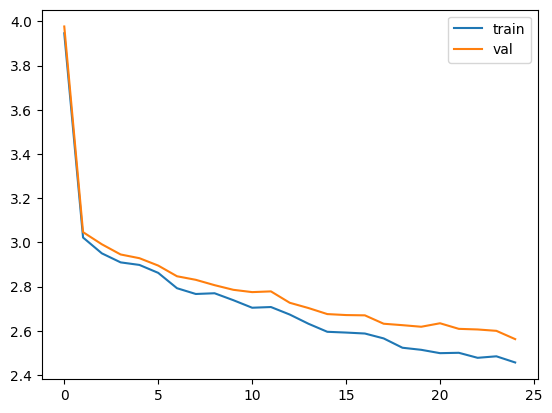

In [12]:
train(model, optimizer, ModelArgs)

In [13]:
## Step 5: Inference Llama 3 Model:
# This function generates text sequences based on provided prompts using the LLama 3 model we've built and trained.

def generate(model, prompts: str, params: ModelArgs, max_gen_len: int=500, temperature: float = 0.6, top_p: float = 0.9):

    # prompt_tokens: List of user input texts or prompts
    # max_gen_len: Maximum length of the generated text sequence.
    # temperature: Temperature value for controlling randomness in sampling. Defaults to 0.6.
    # top_p: Top-p probability threshold for sampling prob output from the logits. Defaults to 0.9.
    # prompt_tokens = [0]
    bsz = 1  #For inferencing, in general user just input one prompt which we'll take it as 1-batch
    prompt_tokens = token_bos.tolist() + encode(prompts)
    assert len(prompt_tokens) <= params.max_seq_len, "prompt token length should be small than max_seq_len"
    total_len = min(len(prompt_tokens)+max_gen_len, params.max_seq_len)   

    # this tokens matrix is to store the input prompts and all the output that is generated by model.
    # later we'll use the tokenizers decode function to decode this token to view results in text format
    tokens = torch.full((bsz,total_len), fill_value=token_pad.item(), dtype=torch.long, device=params.device)

    # fill in the prompt tokens into the token matrix
    tokens[:,:len(prompt_tokens)] = torch.tensor(prompt_tokens, dtype=torch.long, device=params.device)

    #create a prompt_mask_token for later use to identify if the token is a prompt token or a padding token
    # True if it is a prompt token, False if it is a padding token
    input_text_mask = tokens != token_pad.item()

    #now we can start inferencing using one token at a time from the prompt_tokens list starting with the first position.
    prev_pos = 0
    for cur_pos in range(1, total_len):
      with torch.no_grad():
        logits, _ = model(x=tokens[:,prev_pos:cur_pos], start_pos=prev_pos)
      if temperature > 0:      
        probs = torch.softmax(logits[:, -1]/temperature, dim=-1)
        next_token = sample_top_p(probs, top_p)        
      else:
        next_token = torch.argmax(logits[:, -1], dim=-1)        

      next_token = next_token.reshape(-1)

      # only replace the token if it's a padding token
      next_token = torch.where(input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token)
      tokens[:, cur_pos] = next_token

      prev_pos = cur_pos
      if tokens[:,cur_pos]==token_pad.item() and next_token == token_eos.item():
        break

    output_tokens, output_texts = [], []    

    for i, toks in enumerate(tokens.tolist()):
      # eos_idx = toks.index(token_eos.item())
      if token_eos.item() in toks:
        eos_idx = toks.index(token_eos.item())
        toks = toks[:eos_idx]

      output_tokens.append(toks)
      output_texts.append(decode(toks))
    return output_tokens, output_texts

# Perform top-p (nucleus) sampling on a probability distribution.
# probs (torch.Tensor): Probability distribution tensor derived from the logits.
# p: Probability threshold for top-p sampling.
# According to the paper, Top-p sampling selects the smallest set of tokens whose cumulative probability mass exceeds the threshold p. 
# The distribution is renormalized based on the selected tokens.
def sample_top_p(probs, p):
    probs_sort, prob_idx = torch.sort(probs, dim=-1, descending=True)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    mask = probs_sum - probs_sort > p
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    next_token = torch.multinomial(probs_sort, num_samples=1)
    next_token = torch.gather(prob_idx, -1, next_token)    
    # Sampled token indices from the vocabular is returned 
    return next_token

In [15]:
## Perform the inferencing on user input prompts
prompts = "Consider you what services he has done"
output_tokens, output_texts = generate(model, prompts, ModelArgs)
output_texts = output_texts[0].replace("<|begin_of_text|>", "")
print(output_texts)

## Output ##
"""
Consider you what services he has done o eretrane
adetranytnn i eey i ade hs rcuh i eey,ad hsatsTns rpae,T
eon o i hseflns o i eee ee hs ote i ocal ersl,Bnnlnface
o i hmr a il nwye ademto nt i a ere
h i ees.
Frm oe o etrane o oregae,alh,t orede i oeral
"""

Consider you what services he has done
n ee eeede n eetne frm hser i asad i ofe
o rsetet hsedts osae adetsda o ete oes
ad eee o on eetl hvnsne eee nt oe
hsl ode o adent eeetdie o adue a i amn
i lses o i oe otth ady
hre o hreto abete atan o i hsetrt adse a


'\nConsider you what services he has done o eretrane\nadetranytnn i eey i ade hs rcuh i eey,ad hsatsTns rpae,T\neon o i hseflns o i eee ee hs ote i ocal ersl,Bnnlnface\no i hmr a il nwye ademto nt i a ere\nh i ees.\nFrm oe o etrane o oregae,alh,t orede i oeral\n'